In [3]:
from relbench.datasets import get_dataset

In [4]:
dataset = get_dataset("rel-f1")

In [5]:
db = dataset.get_db()

loading Database object from /afs/cs.stanford.edu/u/ranjanr/.cache/relbench/rel-f1/db...
done in 0.04 seconds.


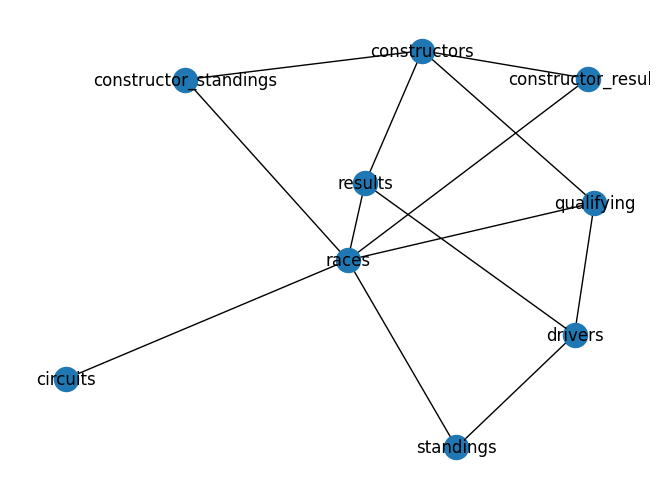

In [6]:
db.plot_schema()

In [14]:
import json
from pathlib import Path
from torch_frame import stype

from relbench.datasets import get_dataset

def get_schema(dataset, cache_dir="/lfs/local/0/ranjanr/.cache/relbench_examples"):
    dset = get_dataset(name=dataset)

    stypes_cache_path = Path(f"{cache_dir}/{dataset}/stypes.json")
    try:
        with open(stypes_cache_path, "r") as f:
            col_to_stype_dict = json.load(f)
        for table, col_to_stype in col_to_stype_dict.items():
            for col, stype_str in col_to_stype.items():
                col_to_stype[col] = stype(stype_str)
    except FileNotFoundError:
        col_to_stype_dict = get_stype_proposal(dataset.get_db())
        Path(stypes_cache_path).parent.mkdir(parents=True, exist_ok=True)
        with open(stypes_cache_path, "w") as f:
            json.dump(col_to_stype_dict, f, indent=2, default=str)
    
    table2stype = col_to_stype_dict
    table2stype_name = {}
    for name, stype_ in table2stype.items():
        table2stype_name[name] = {i: j.name for i,j in stype_.items()}
    
    table2pkey = {}
    table2fkeys = {}
    for name,table in dset.get_db().table_dict.items():
        table2pkey[name] = table.pkey_col
        table2fkeys[name] = table.fkey_col_to_pkey_table
    
    
    # Function to map simplified type names to more SQL-like type names
    def map_type(simple_type):
        type_mappings = {
            'numerical': 'numerical',
            'categorical': 'categorical',
            'text_embedded': 'text',
            'timestamp': 'timestamp'
        }
        return type_mappings.get(simple_type, 'varchar')
    
    # Generate table definitions
    output = []
    for table, columns in table2stype_name.items():
        output.append(f"Table {table} {{")
        for column, simple_type in columns.items():
            column_type = map_type(simple_type)
            pk_indicator = " [primary key]" if table2pkey.get(table) == column else ""
            output.append(f"  {column} {column_type}{pk_indicator}")
        output.append("}\n")
    
    # Generate foreign key references
    for table, fkeys in table2fkeys.items():
        for column, ref_table in fkeys.items():
            output.append(f"Ref: {table}.{column} > {ref_table}.{table2pkey[ref_table]}")
    
    # Print output
    print("\n".join(output))
    
get_schema('rel-avito')

loading Database object from /afs/cs.stanford.edu/u/ranjanr/.cache/relbench/rel-avito/db...
done in 3.76 seconds.
Table PhoneRequestsStream {
  UserID numerical
  IPID numerical
  AdID numerical
  PhoneRequestDate timestamp
}

Table SearchStream {
  SearchID numerical
  AdID numerical
  Position numerical
  ObjectType numerical
  HistCTR numerical
  IsClick categorical
  SearchDate timestamp
}

Table UserInfo {
  UserID numerical [primary key]
  UserAgentID numerical
  UserAgentOSID numerical
  UserDeviceID numerical
  UserAgentFamilyID numerical
}

Table Location {
  LocationID numerical [primary key]
  Level numerical
  RegionID numerical
  CityID numerical
}

Table VisitStream {
  UserID numerical
  IPID numerical
  AdID numerical
  ViewDate timestamp
}

Table SearchInfo {
  UserID numerical
  SearchID numerical [primary key]
  SearchDate timestamp
  IPID numerical
  IsUserLoggedOn numerical
  SearchQuery text
  LocationID numerical
  CategoryID categorical
}

Table AdsInfo {
  AdID